#### !pip install spacy

In [3]:
# Код для анализа технической документации: сложность и стилевые особенности
import json
import re
import pandas as pd
import numpy as np
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from spacy.matcher import Matcher
from spacy.tokens import Doc

In [5]:
!python -m spacy download ru_core_news_md

     ---------------------------------------- 41.9/41.9 MB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 53.8/53.8 kB 2.7 MB/s eta 0:00:00
     ---------------------------------------- 8.4/8.4 MB 3.1 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('ru_core_news_md')


In [4]:
# Загрузка модели русского языка
nlp = spacy.load("ru_core_news_md")

In [7]:
# Путь к файлу
filepath = './spacy_annotations_2.json'

In [9]:
def load_corpus(filepath):
    """Загружает корпус из JSON-файла."""
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

In [11]:
def analyze_text_blocks(corpus):
    """Анализирует текстовые блоки с расчетом метрик."""
    results = []
    
    # Обрабатываем каждый текстовый блок
    for i, block in tqdm(enumerate(corpus), total=len(corpus), desc="Анализ блоков"):
        text = block.get('text', '')
        if not text or len(text.strip()) < 10:
            continue
            
        doc = nlp(text)
        
        # Собираем базовые статистики
        stats = {
            'block_id': i,
            'text': text,
            'chars': len(text),
            'words': len([t for t in doc if not t.is_punct and not t.is_space]),
            'sentences': len(list(doc.sents)),
        }
        
        # Добавляем все метрики
        stats.update(complexity_metrics(doc))
        stats.update(style_metrics(doc))
        stats.update(tone_metrics(doc))
        stats.update(syntax_metrics(doc))
        
        # Определяем кандидатов для исправления
        needs_improvement = is_candidate_for_improvement(doc, stats)
        stats['needs_improvement'] = needs_improvement
        stats['improvement_reasons'] = get_improvement_reasons(doc, stats)
        
        results.append(stats)
    
    return pd.DataFrame(results)

In [13]:
def complexity_metrics(doc):
    """Метрики когнитивной сложности текста."""
    metrics = {}
    
    # Средняя длина слов и предложений
    words = [t for t in doc if not t.is_punct and not t.is_space]
    sentences = list(doc.sents)
    
    metrics['avg_word_length'] = np.mean([len(w.text) for w in words]) if words else 0
    metrics['avg_sent_length'] = np.mean([len([t for t in sent if not t.is_punct and not t.is_space]) 
                                         for sent in sentences]) if sentences else 0
    
    # Метрики Шпаковского
    words_count = len(words)
    long_words = sum(1 for w in words if len(w.text) > 10)
    metrics['long_words_ratio'] = long_words / words_count if words_count > 0 else 0
    
    # Лексическое разнообразие (TTR - Type-Token Ratio)
    unique_lemmas = set(t.lemma_ for t in words)
    metrics['lexical_diversity'] = len(unique_lemmas) / words_count if words_count > 0 else 0
    
    # Глубина синтаксических структур
    max_depth = 0
    avg_depths = []
    
    for token in doc:
        depth = 0
        current = token
        while current.head != current:
            depth += 1
            current = current.head
        max_depth = max(max_depth, depth)
        avg_depths.append(depth)
    
    metrics['max_syntactic_depth'] = max_depth
    metrics['avg_syntactic_depth'] = np.mean(avg_depths) if avg_depths else 0
    
    # Сложность по Флэшу-Кинкейду (адаптированная для русского)
    if len(sentences) > 0 and words_count > 0:
        syllables = count_syllables_in_doc(doc)
        metrics['flesch_kincaid_grade'] = 0.5 * metrics['avg_sent_length'] + 8.4 * (syllables / words_count) - 15.59
    else:
        metrics['flesch_kincaid_grade'] = 0
    
    return metrics

In [15]:
def count_syllables_in_doc(doc):
    """Примерный подсчет слогов для русского языка."""
    vowels = set('аеёиоуыэюя')
    syllables = 0
    
    for token in doc:
        if token.is_alpha:
            word_syllables = sum(1 for char in token.text.lower() if char in vowels)
            syllables += max(1, word_syllables)  # Минимум 1 слог
    
    return syllables

In [17]:
def style_metrics(doc):
    """Стилистические метрики текста."""
    metrics = {}
    
    # Части речи
    pos_counts = Counter([token.pos_ for token in doc])
    for pos, count in pos_counts.items():
        metrics[f'pos_{pos}'] = count
    
    total_tokens = len(doc)

    # Соотношения частей речи
    metrics['noun_ratio'] = pos_counts.get('NOUN', 0) / total_tokens if total_tokens > 0 else 0
    metrics['verb_ratio'] = pos_counts.get('VERB', 0) / total_tokens if total_tokens > 0 else 0
    metrics['adj_ratio'] = pos_counts.get('ADJ', 0) / total_tokens if total_tokens > 0 else 0
    
    # Подсчет причастий
    participles = [token for token in doc if token.pos_ == "VERB" and token.morph.get("VerbForm") == ["Part"]]

    # Подсчет деепричастий
    converbs = [token for token in doc if token.pos_ == "VERB" and token.morph.get("VerbForm") == ["Conv"]]

    
    metrics['participles_count'] = len(participles)
    metrics['gerunds_count'] = len(converbs)
    
    # Последовательные существительные
    consecutive_nouns = find_consecutive_nouns(doc)
    metrics['max_consecutive_nouns'] = max([len(group) for group in consecutive_nouns]) if consecutive_nouns else 0
    metrics['consecutive_nouns_groups'] = len(consecutive_nouns)
    metrics['three_plus_consecutive_nouns'] = sum(1 for group in consecutive_nouns if len(group) >= 3)

    # Канцеляризмы и клише
    bureaucratic_phrases = [
    # Предложные конструкции
    'в целях', 'в соответствии с', 'в связи с', 'в случае', 'в процессе',
    'на основании', 'путем', 'в течение', 'в рамках', 'по причине',
    'в ходе', 'в отношении', 'в части', 'со стороны', 'за счет',
    'по линии', 'в порядке', 'в силу', 'в адрес', 'при условии',
    'в качестве', 'на предмет', 'во избежание', 'в направлении',
    'посредством', 'по мере', 'в результате', 'в виде',
    'с целью', 'при наличии', 'при отсутствии', 'на уровне',
    'по факту', 'в дополнение к', 'согласно', 'вследствие',
    'применительно к', 'относительно', 'касательно', 'касаемо',
    
    # Указательные канцеляризмы
    'вышеуказанный', 'нижеследующий', 'вышеприведенный', 'вышеперечисленный',
    'вышесказанный', 'вышеизложенный', 'нижеприведенный', 'указанный',
    'упомянутый', 'отмеченный', 'соответствующий', 'надлежащий',
    'означенный', 'поименованный', 'следующий', 'настоящий',
    
    # Деепричастные обороты канцелярского типа
    'принимая во внимание', 'учитывая обстоятельства', 'исходя из',
    'руководствуясь', 'учитывая вышеизложенное', 'исходя из положений',
    'основываясь на', 'опираясь на', 'ориентируясь на', 'имея в виду',
    'считая необходимым', 'полагая', 'предполагая', 'обращая внимание',
    
    # Канцелярские глагольно-именные сочетания
    'произвести запуск', 'осуществить выполнение', 'произвести установку',
    'осуществить настройку', 'произвести активацию', 'выполнить запуск',
    'осуществить вход', 'произвести обновление', 'осуществить открытие',
    'произвести закрытие', 'осуществить проверку', 'произвести изменение',
    'осуществить переход', 'произвести подключение', 'осуществить удаление',
    'произвести создание', 'осуществить загрузку', 'произвести сохранение',
    'осуществить копирование', 'произвести перемещение', 'осуществить поиск',
    'произвести выбор', 'осуществить ввод', 'произвести вывод',
    
    # Формально-канцелярские клише
    'имеет место быть', 'имеет место', 'играет роль', 'оказывает влияние',
    'подлежит применению', 'подлежит исполнению', 'подлежит удалению',
    'подлежит рассмотрению', 'подлежит замене', 'подлежит установке',
    'принять к сведению', 'принять меры', 'принять во внимание',
    'довести до сведения', 'приступить к выполнению', 'приступить к работе',
    
    # Канцелярские сложные союзы и связки
    'в связи с тем что', 'в силу того что', 'ввиду того что',
    'в то время как', 'вместе с тем', 'по мере того как',
    'с тем чтобы', 'таким образом чтобы', 'в случае если',
    'в течение времени пока', 'несмотря на то что',
    'в соответствии с тем что', 'по причине того что',

    # Бюрократические штампы
    'вопрос повестки дня', 'в установленном порядке', 'настоящим сообщаем',
    'надлежащим образом', 'в кратчайшие сроки', 'должным образом',
    'текущий момент времени', 'считается целесообразным', 'является необходимым',
    'доводим до вашего сведения', 'обращаем ваше внимание',
    'уведомляем о том что', 'настоящее руководство',
    
    # Устойчивые канцелярские конструкции
    'следует отметить', 'необходимо подчеркнуть', 'стоит упомянуть',
    'целесообразно указать', 'важно понимать', 'необходимо учитывать',
    'представляется возможным', 'представляется необходимым',
    'предполагается что', 'нельзя не учитывать', 'следует иметь в виду',
    
    # Отглагольные существительные с канцелярским оттенком
    'осуществление', 'выполнение', 'производство', 'применение',
    'использование', 'функционирование', 'обеспечение',
    'формирование', 'реализация', 'эксплуатация',
    
    # Технические канцеляризмы
    'в техническом отношении', 'с технической точки зрения',
    'в вышеописанном контексте', 'в соответствии со спецификацией',
    'с учетом вышеизложенного', 'в соответствии с инструкцией',
    'в соответствии с руководством', 'при возникновении необходимости',
    'в ходе эксплуатации', 'в процессе работы системы'
    ]
    
    metrics['bureaucratic_phrases'] = sum(1 for phrase in bureaucratic_phrases 
                                         if re.search(r'\b' + phrase + r'\b', doc.text.lower()))
    
    return metrics

In [19]:
def find_consecutive_nouns(doc):
    """Находит группы последовательных существительных."""
    groups = []
    current_group = []
    
    for token in doc:
        if token.pos_ == 'NOUN':
            current_group.append(token)
        else:
            if len(current_group) >= 2:  # Минимум 2 существительных подряд
                groups.append(current_group)
            current_group = []
    
    # Проверка последней группы
    if len(current_group) >= 2:
        groups.append(current_group)
    
    return groups

In [21]:
def tone_metrics(doc):
    """Метрики коммуникативного тона."""
    metrics = {}
    
    text = doc.text.lower()
    
    # Подсчет модальных конструкций
    modal_words = [
    # Необходимость и долженствование
    'необходимо', 'нужно', 'надо', 'надобно', 'следует', 'требуется', 'стоит', 'полагается',
    'должен', 'должны', 'должна', 'должно', 'обязан', 'обязаны', 'обязана', 'обязано',
    'приходится', 'придется', 'надлежит', 'положено', 'подобает', 'предписывается',
    
    # Возможность
    'можно', 'возможно', 'допустимо', 'позволительно', 'разрешается', 'допускается',
    'могут', 'может', 'в состоянии', 'в силах', 'способен', 'способны',
    
    # Вероятность и предположение
    'вероятно', 'возможно', 'по-видимому', 'пожалуй', 'наверное', 'наверняка',
    'очевидно', 'скорее всего', 'похоже', 'кажется', 'представляется',
    
    # Рекомендации и советы
    'рекомендуется', 'советуется', 'желательно', 'предпочтительно', 'лучше',
    'целесообразно', 'уместно', 'разумно', 'имеет смысл', 'стоит',
    
    # Запрет
    'нельзя', 'запрещается', 'запрещено', 'не допускается', 'не разрешается',
    'не позволяется', 'воспрещается', 'не рекомендуется', 'не следует',
    
    # Устойчивые модальные конструкции
    'имеет значение', 'играет роль', 'есть необходимость', 'есть смысл',
    'представляется важным', 'считается необходимым', 'принято считать',
    'следует отметить', 'важно помнить', 'важно учесть', 'следует учитывать',
    'необходимо помнить', 'необходимо учитывать', 'не стоит забывать',
    
    # Условные модальные конструкции
    'при необходимости', 'в случае необходимости', 'по мере возможности',
    'при условии', 'по возможности', 'при желании'
    ]
    metrics['modal_constructions'] = sum(1 for word in modal_words if re.search(r'\b' + word + r'\b', text))
    
    # Подсчет указательных слов
    pointer_words = [
    # Классические указательные
    'данный', 'следующий', 'настоящий', 'текущий', 'этот', 'тот', 'такой',
    'таковой', 'указанный', 'упомянутый', 'вышеуказанный', 'нижеуказанный',
    
    # Производные и склонения
    'данного', 'данному', 'данным', 'данном', 'данная', 'данной', 'данную', 
    'данные', 'данных', 'данными',
    'следующего', 'следующему', 'следующим', 'следующем', 'следующая', 'следующей', 
    'следующую', 'следующие', 'следующих', 'следующими',
    'вышеупомянутый', 'вышеозначенный', 'вышеприведенный', 'вышеназванный',
    'нижеупомянутый', 'нижеозначенный', 'нижеприведенный', 'нижеследующий',
    
    # Формальные замены для "этот"
    'данный', 'настоящий', 'предлагаемый', 'рассматриваемый', 'описываемый',
    'представленный', 'указанный', 'означенный', 'соответствующий',
    
    # Канцелярские пространственные указатели
    'вышестоящий', 'нижестоящий', 'вышеозначенный', 'нижеозначенный',
    'предшествующий', 'последующий', 'прилагаемый',
    
    # Временные указатели формального стиля
    'вышеизложенный', 'нижеизложенный', 'настоящий', 'текущий',
    'предыдущий', 'дальнейший', 'предстоящий', 'грядущий',
    
    # Формальные локативные конструкции
    'в данном случае', 'в настоящем документе', 'в указанном месте',
    'в рассматриваемом примере', 'на данном этапе', 'в данной ситуации',
    'в описываемых условиях', 'в представленном виде',
    
    # Вводные конструкции указательного характера
    'таким образом', 'следовательно', 'в результате', 'исходя из этого',
    'в связи с этим', 'в соответствии с этим', 'на основании вышеизложенного',
    
    # Формальные связующие конструкции
    'вместе с тем', 'тем не менее', 'при этом', 'в то же время',
    'кроме того', 'более того', 'помимо этого', 'наряду с этим'
    ]
    metrics['pointer_words'] = sum(1 for word in pointer_words if re.search(r'\b' + word + r'\b', text))
    
    # Определение пассивных конструкций
    passive_matches = [t for t in doc if t.pos_ == "VERB" and "Voice=Pass" in t.morph.get("Voice") or 
                      (t.tag_ == "VERB" and "Pass" in t.morph.get("Voice", []))]
    metrics['passive_constructions'] = len(passive_matches)
    
    # Определение директивности (императивные глаголы) - это ПОЛОЖИТЕЛЬНАЯ метрика
    imperatives = [t for t in doc if t.pos_ == 'VERB' and 'Imp' in t.morph.get('Mood', [])]
    metrics['imperative_constructions'] = len(imperatives)
    
    # Обращение напрямую (по наличию "вы", "ваш" и т.д.)
    direct_address = sum(1 for t in doc if t.text.lower() in ['вы', 'ваш', 'вам', 'вас'])
    metrics['direct_address'] = direct_address
    
    # Определение формальности текста
    formal_markers = [
    # Вежливые слова
    'пожалуйста', 'благодарим', 'благодарю', 'спасибо', 'будьте добры', 
    'будьте любезны', 'позвольте', 'разрешите', 'не откажите', 'соблаговолите',
    
    # Выражения благодарности
    'выражаем благодарность', 'благодарим вас', 'выражаем признательность',
    'примите нашу благодарность', 'благодарим за внимание', 'благодарим за понимание',
    'с благодарностью', 'заранее благодарим', 'заранее признательны',
    
    # Формальные извинения
    'приносим извинения', 'приносим свои извинения', 'просим прощения',
    'просим извинить', 'сожалеем о', 'примите наши извинения', 'прошу прощения',
    
    # Вежливые просьбы
    'не могли бы вы', 'будем признательны', 'будем благодарны', 'прошу вас',
    'просим вас', 'убедительно просим', 'не затруднит ли вас', 'просьба',
    
    # Формальные приветствия и прощания
    'уважаемый', 'уважаемая', 'уважаемые', 'с уважением', 'искренне ваш',
    'с наилучшими пожеланиями', 'всего доброго', 'всего наилучшего',
    
    # Формальные обороты
    'доводим до вашего сведения', 'информируем вас', 'ставим вас в известность',
    'сообщаем вам', 'обращаем ваше внимание', 'напоминаем вам', 
    'смеем заверить', 'уверяем вас', 'позвольте заверить',
    
    # Дополнительные формальные выражения
    'имеем честь', 'считаем своим долгом', 'считаем необходимым',
    'считаем целесообразным', 'считаем возможным', 'считаем уместным',
    
    # Формулы вежливости
    'если вас не затруднит', 'если возможно', 'при вашем согласии',
    'с вашего позволения', 'с вашего разрешения', 'по вашему усмотрению',
    'на ваше усмотрение'
    ]
        
    metrics['formality_markers'] = sum(1 for marker in formal_markers if re.search(r'\b' + marker + r'\b', text))
    
    return metrics

In [23]:
def syntax_metrics(doc):
    """Метрики синтаксической структуры."""
    metrics = {}
    
    # Средняя длина клаузы (предложения с финитным глаголом)
    clauses = []
    current_clause = []
    
    for sent in doc.sents:
        verbs = [t for t in sent if t.pos_ == 'VERB' and 'Fin' in t.morph.get('VerbForm', [])]
        if not verbs:
            # Если нет финитных глаголов, считаем предложение одной клаузой
            clauses.append(list(sent))
        else:
            # Иначе разбиваем по финитным глаголам
            last_idx = 0
            for verb in verbs:
                # Приблизительное разделение на клаузы
                clause_tokens = [t for t in sent if last_idx <= t.i <= verb.i]
                if clause_tokens:
                    clauses.append(clause_tokens)
                    last_idx = verb.i + 1
            
            # Добавляем остаток предложения
            remaining = [t for t in sent if t.i >= last_idx]
            if remaining:
                clauses.append(remaining)
    
    metrics['clause_count'] = len(clauses)
    metrics['avg_clause_length'] = np.mean([len(clause) for clause in clauses]) if clauses else 0
    
    # Сложные предложения (с несколькими клаузами)
    sentences = list(doc.sents)
    complex_sentences = 0
    
    for sent in sentences:
        finite_verbs = [t for t in sent if t.pos_ == 'VERB' and 'Fin' in t.morph.get('VerbForm', [])]
        if len(finite_verbs) > 1:
            complex_sentences += 1
    
    metrics['complex_sentences'] = complex_sentences
    metrics['complex_sentences_ratio'] = complex_sentences / len(sentences) if sentences else 0
    
    return metrics

In [25]:
def is_candidate_for_improvement(doc, stats):
    """Определяет, является ли текст кандидатом для улучшения."""
    # Проверяем условия для улучшения
    conditions = [
        stats['flesch_kincaid_grade'] > 13,  # Индекс сложности Флеша
        stats['pointer_words'] > 0,  # Использование слов "данный", "следующий"
        stats['modal_constructions'] > 0,  # Избыточная модальность
        stats['three_plus_consecutive_nouns'] > 0,  # Три и более существительных подряд
        stats['passive_constructions'] > 1,  # Пассивные конструкции
        stats['bureaucratic_phrases'] > 0,  # Канцеляризмы
        stats['complex_sentences_ratio'] > 0.4,  # Более 40% сложных предложений
        stats['max_syntactic_depth'] > 5,  # Глубокие синтаксические структуры
        stats['avg_sent_length'] > 20,  # Длинные предложения
        stats['participles_count'] > 2,  # Много причастий
        stats['gerunds_count'] > 2,  # Много деепричастий
        stats['direct_address'] == 0 and len(list(doc.sents)) > 1,  # Нет прямого обращения в тексте с >1 предложением
        stats['long_words_ratio'] > 0.3,  # Высокая доля длинных слов (метрика Шпаковского)
        stats['formality_markers'] > 2,  # Высокое количество формальных маркеров
        stats['avg_clause_length'] > 15,  # Длинные клаузы
        stats['noun_ratio'] > 0.4,  # Избыточное количество существительных
        stats['adj_ratio'] > 0.25,  # Высокая доля прилагательных
    ]
    
    # Если хотя бы три условия выполняются, текст нуждается в улучшении
    return sum(conditions) >= 7

In [27]:
def get_improvement_reasons(doc, stats):
    """Возвращает причины, по которым текст нуждается в улучшении."""
    reasons = []
    
    if stats['flesch_kincaid_grade'] > 13:
        reasons.append("Индекс сложности по Флешу Кинкейду больше 13 - уровень бакалавра")
        
    if stats['pointer_words'] > 0:
        reasons.append("Использование указательных слов 'данный', 'следующий'")
    
    if stats['modal_constructions'] > 0:
        reasons.append("Избыточная модальность ('необходимо', 'нужно', 'следует')")
    
    if stats['three_plus_consecutive_nouns'] > 0:
        reasons.append("Три и более существительных подряд")
    
    if stats['passive_constructions'] > 1:
        reasons.append("Пассивные конструкции")
    
    if stats['bureaucratic_phrases'] > 0:
        reasons.append("Канцеляризмы и клише")
    
    if stats['complex_sentences_ratio'] > 0.4:
        reasons.append("Высокий процент сложных предложений")
    
    if stats['max_syntactic_depth'] > 5:
        reasons.append("Глубокие синтаксические структуры")
    
    if stats['avg_sent_length'] > 20:
        reasons.append("Длинные предложения")
    
    if stats['participles_count'] > 2:
        reasons.append("Много причастий")
    
    if stats['gerunds_count'] > 2:
        reasons.append("Много деепричастий")
    
    if stats['direct_address'] == 0 and len(list(doc.sents)) > 1:
        reasons.append("Отсутствие прямого обращения к пользователю")
    
    if stats['long_words_ratio'] > 0.3:
        reasons.append("Высокая доля длинных слов (более 10 букв)")
    
    if stats['formality_markers'] > 2:
        reasons.append("Избыточный формальный стиль")
    
    if stats['avg_clause_length'] > 15:
        reasons.append("Длинные клаузы (смысловые части предложений)")
    
    if stats['noun_ratio'] > 0.4:
        reasons.append("Перегруженность существительными")
    
    if stats['adj_ratio'] > 0.25:
        reasons.append("Избыточное количество прилагательных")
    
    return reasons

In [29]:
def generate_statistics(df):
    """Генерирует и визуализирует статистику по всему корпусу."""
    print("=== ОБЩАЯ СТАТИСТИКА ПО КОРПУСУ ===")
    
    # Общие цифры
    print(f"Всего блоков текста: {len(df)}")
    print(f"Кандидаты на улучшение: {df['needs_improvement'].sum()} ({df['needs_improvement'].mean()*100:.1f}%)")
    
    # Средние значения ключевых метрик
    print("\n=== СРЕДНИЕ ЗНАЧЕНИЯ МЕТРИК ===")
    metrics_to_show = [
        'avg_sent_length', 'avg_word_length', 'max_syntactic_depth', 
        'flesch_kincaid_grade', 'participles_count', 'gerunds_count',
        'passive_constructions', 'modal_constructions', 'pointer_words',
        'bureaucratic_phrases', 'complex_sentences_ratio', 'long_words_ratio',
        'lexical_diversity', 'noun_ratio', 'verb_ratio', 'adj_ratio',
        'max_consecutive_nouns', 'consecutive_nouns_groups', 'three_plus_consecutive_nouns',
        'imperative_constructions', 'direct_address', 'formality_markers', 'clause_count',
        'avg_clause_length'
    ]

    for metric in metrics_to_show:
        if metric in df.columns:
            print(f"{metric}: {df[metric].mean():.2f}")
    
    # Причины улучшения
    print("\n=== ПРИЧИНЫ ДЛЯ УЛУЧШЕНИЯ ===")
    # Распаковываем список причин из всех блоков
    all_reasons = []
    for reasons in df['improvement_reasons'].dropna():
        all_reasons.extend(reasons)
    
    reason_counts = Counter(all_reasons)
    for reason, count in reason_counts.most_common():
        print(f"{reason}: {count} случаев ({count/len(df)*100:.1f}%)")
    
    # Создание визуализаций
    plt.figure(figsize=(12, 8))
    
    # График распределения длины предложений
    plt.subplot(2, 2, 1)
    sns.histplot(df['avg_sent_length'], kde=True)
    plt.title('Распределение средней длины предложений')
    plt.xlabel('Слов в предложении')
    
    # График сложности по Флэш-Кинкейду
    plt.subplot(2, 2, 2)
    sns.histplot(df['flesch_kincaid_grade'], kde=True)
    plt.title('Распределение сложности по Флэш-Кинкейду')
    plt.xlabel('Уровень сложности')
    
    # Топ причин для улучшения
    plt.subplot(2, 2, 3)
    top_reasons = pd.Series(reason_counts).nlargest(7)
    sns.barplot(x=top_reasons.values, y=top_reasons.index)
    plt.title('Топ-7 причин для улучшения текста')
    plt.xlabel('Количество')
    
    # Корреляция между метриками
    plt.subplot(2, 2, 4)
    corr_metrics = df[metrics_to_show].corr()
    sns.heatmap(corr_metrics, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Корреляция между метриками')
    
    plt.tight_layout()
    plt.savefig('corpus_statistics_5.png', dpi=300)
    plt.show()
    
    # Сохраняем кандидатов на улучшение
    improvement_candidates = df[df['needs_improvement']]
    improvement_candidates.to_csv('improvement_candidates_5.csv', index=False)
    print(f"\nСохранено {len(improvement_candidates)} кандидатов на улучшение в файл 'improvement_candidates.csv'")
    
    return df

Анализ блоков: 100%|██████████████████████| 29560/29560 [41:43<00:00, 11.81it/s]


=== ОБЩАЯ СТАТИСТИКА ПО КОРПУСУ ===
Всего блоков текста: 29560
Кандидаты на улучшение: 10966 (37.1%)

=== СРЕДНИЕ ЗНАЧЕНИЯ МЕТРИК ===
avg_sent_length: 10.61
avg_word_length: 6.22
max_syntactic_depth: 6.73
flesch_kincaid_grade: 11.15
participles_count: 3.24
gerunds_count: 0.35
passive_constructions: 3.24
modal_constructions: 1.71
pointer_words: 0.84
bureaucratic_phrases: 0.82
complex_sentences_ratio: 0.17
long_words_ratio: 0.12
lexical_diversity: 0.66
noun_ratio: 0.31
verb_ratio: 0.12
adj_ratio: 0.08
max_consecutive_nouns: 3.05
consecutive_nouns_groups: 9.04
three_plus_consecutive_nouns: 2.01
imperative_constructions: 4.99
direct_address: 0.56
formality_markers: 0.04
clause_count: 22.96
avg_clause_length: 7.17

=== ПРИЧИНЫ ДЛЯ УЛУЧШЕНИЯ ===
Три и более существительных подряд: 21714 случаев (73.5%)
Глубокие синтаксические структуры: 21665 случаев (73.3%)
Отсутствие прямого обращения к пользователю: 21411 случаев (72.4%)
Избыточная модальность ('необходимо', 'нужно', 'следует'): 21226 слу

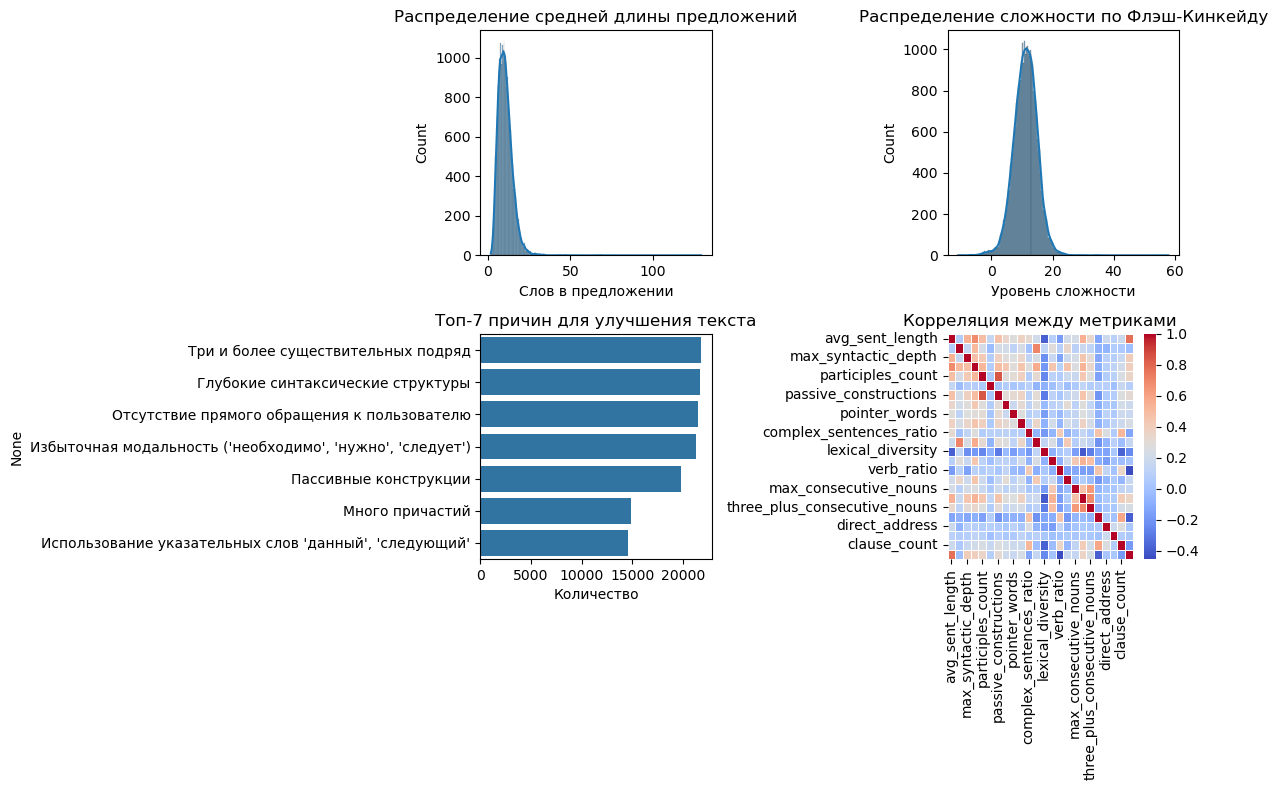


Сохранено 10966 кандидатов на улучшение в файл 'improvement_candidates.csv'
Полные результаты анализа сохранены в файл 'all_metrics.csv'


In [31]:
if __name__ == "__main__":
    # Путь к файлу с корпусом
    corpus_file = './spacy_annotations_2.json'  # Замените на реальный путь
    
    # Загрузка корпуса
    corpus = load_corpus(corpus_file)
    
    # Анализ текстовых блоков
    results_df = analyze_text_blocks(corpus)
    
    # Генерация статистики
    generate_statistics(results_df)
    
    # Сохранение всех метрик
    results_df.to_csv('all_metrics_5.csv', index=False)
    print(f"Полные результаты анализа сохранены в файл 'all_metrics.csv'")